In [44]:
import time

import matplotlib.pyplot as plt
import numpy as np
from meegkit.trca import TRCA

from preprocessing import BCIDataProcessor

In [45]:
recording_path = '../recordings/recording_ssvep4_gel.raw.fif'
window_size = 2
window_overlap = 1
processor = BCIDataProcessor(recording_path, l_freq=1, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process()

In [46]:
# Step 1: Gather all trials into a list
all_trials = []
all_labels = []

# Map frequencies to label numbers
freqs = sorted(map(float, data.keys()))  # sorted list of frequencies
freq_to_label = {freq: idx for idx, freq in enumerate(freqs)}
freqs

[11.0, 15.0, 19.0, 23.0]

In [47]:
for freq_str, eeg_trials in data.items():
    freq = float(freq_str)
    label = freq_to_label[freq]  # integer label for this frequency

    all_trials.append(eeg_trials)  # shape (n_trials, n_channels, n_samples)
    print(eeg_trials.shape)
    all_labels.extend([label] * eeg_trials.shape[0])

(45, 8, 500)
(45, 8, 500)
(45, 8, 500)
(45, 8, 500)


In [48]:
# Step 2: Stack all trials
# Now shape will be (total_trials, n_channels, n_samples)
all_trials = np.vstack(all_trials)
all_labels = np.array(all_labels)
all_trials.shape, all_labels.shape

((180, 8, 500), (180,))

In [49]:
# Step 3: Rearrange axes to (samples, channels, trials)
# First: (total_trials, channels, samples) -> (samples, channels, total_trials)
all_trials = np.transpose(all_trials, (2, 1, 0))
all_trials

array([[[ 4.23516474e-22, -1.15160006e-05,  2.44425932e-05, ...,
          2.11758237e-22,  9.79149457e-06,  8.10801335e-07],
        [-1.05879118e-21, -5.64413750e-06,  2.06075783e-05, ...,
          2.11758237e-22,  8.50322175e-07,  1.09879995e-05],
        [-2.54109884e-21, -6.03762629e-06,  2.47499349e-05, ...,
          1.69406589e-21,  7.38710078e-06,  9.08058620e-06],
        ...,
        [-2.09111259e-21, -8.58088791e-06,  1.14578095e-05, ...,
         -1.05879118e-22, -1.31396464e-05,  5.27189023e-06],
        [-2.64697796e-21, -4.18917135e-06,  4.36616162e-06, ...,
          4.23516474e-22, -1.15814300e-05,  1.24146740e-05],
        [-4.23516474e-22, -1.91761906e-06,  1.43911137e-05, ...,
         -1.05879118e-21, -7.06811469e-06,  1.06474957e-05]],

       [[-1.31736784e-06, -9.55426607e-06,  2.22589393e-05, ...,
         -1.45106227e-06,  9.17028523e-06,  9.47961745e-07],
        [-6.83548649e-07, -4.41088762e-06,  2.00428682e-05, ...,
          5.45949382e-07,  2.31430617e

In [50]:
eeg = all_trials
labels = all_labels
eeg.shape, labels.shape

((500, 8, 180), (180,))

In [51]:
t = time.time()

sfreq = 250
n_bands = 5  # number of sub-bands in filter bank analysis
is_ensemble = True  # True = ensemble TRCA method; False = TRCA method
alpha_ci = 0.05  # 100*(1-alpha_ci): confidence interval for accuracy

n_targets = len(freqs)

# Useful variables (no need to modify)
ci = 100 * (1 - alpha_ci)  # confidence interval
n_targets

4

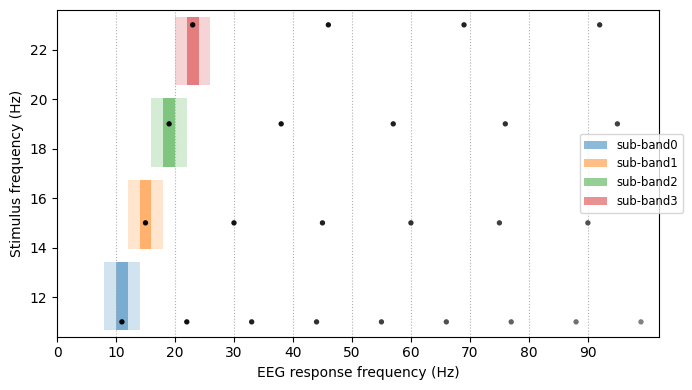

In [56]:
filterbank = [
    [(10, 12), (8, 14)],
    [(14, 16), (12, 18)],
    [(18, 20), (16, 22)],
    [(22, 24), (20, 26)],
    # [(21, 23), (19, 25)],  # around 22 (2×11)
    # [(29, 31), (27, 33)],  # around 30 (2×15)
    # [(37, 39), (35, 41)],  # around 38 (2×19)
    # [(45, 47), (43, 49)]   # around 46 (2×23)
]

f, ax = plt.subplots(1, figsize=(7, 4))
for i, _band in enumerate(filterbank):
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][1][0], xmax=filterbank[i][1][1],
               alpha=0.2, facecolor=f"C{i}")
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][0][0], xmax=filterbank[i][0][1],
               alpha=0.5, label=f"sub-band{i}", facecolor=f"C{i}")

for f in freqs:
    colors = np.ones((9, 4))
    colors[:, :3] = np.linspace(0, .5, 9)[:, None]
    ax.scatter(f * np.arange(1, 10), [f] * 9, c=colors, s=8, zorder=100)

ax.set_ylabel("Stimulus frequency (Hz)")
ax.set_xlabel("EEG response frequency (Hz)")
ax.set_xlim([0, 102])
ax.set_xticks(np.arange(0, 100, 10))
ax.grid(True, ls=":", axis="x")
ax.legend(bbox_to_anchor=(1.05, .5), fontsize="small")
plt.tight_layout()
plt.show()

In [57]:
import numpy as np

# Your EEG and label arrays prepared earlier
# eeg: shape (samples, channels, trials)
# labels: shape (trials,)

trca = TRCA(sfreq, filterbank, is_ensemble)

print("Results of the ensemble TRCA-based method without CV:\n")

# Train TRCA on all available data
trca.fit(eeg, labels)

# Test on the same data (NOTE: this is NOT cross-validation)
estimated = trca.predict(eeg)

# Compute accuracy
is_correct = estimated == labels
accuracy = np.mean(is_correct) * 100

print(f"Accuracy = {accuracy:.1f}%")

# Confidence intervals (optional, but based on a single "measurement")
# mu_acc, _, muci_acc, _ = normfit(np.array([accuracy]), alpha_ci)

# print(f"Mean accuracy = {mu_acc:.1f}% ({ci:.0f}% CI: {muci_acc[0]:.1f}-{muci_acc[1]:.1f}%)")

Results of the ensemble TRCA-based method without CV:

Accuracy = 42.8%
